# Calculate Building Footprint Accuracy in KSA

This Jupyter Notebook calculates the accuracy of building footprint detection by comparing predicted polygons (from Mask R-CNN) against ground truth polygons, both in GeoJSON format. Metrics include Intersection over Union (IoU), precision, recall, and F1-score, tailored for KSA's context (e.g., distinguishing sand, roofs, and yards). The script uses `geopandas` and `shapely` for geospatial analysis and visualizes results for a proof of concept (POC) region.

In [6]:
# Install required libraries (run once if not installed)
%pip install geopandas shapely numpy matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from pathlib import Path

# Set random seed for reproducibility
np.random.seed(42)

In [26]:
# Define input file paths (update with your GeoJSON file paths)

pred_geojson = r"results\Hung\Label_area_Hung_prediction.geojson"  # Mask R-CNN predictions
gt_geojson = r"data\POC4\Labels.geojson"  # Ground truth (e.g., from Address Layer)

# Create output directory for plots
output_dir = Path('accuracy_plots')
output_dir.mkdir(exist_ok=True)

In [27]:
# Load GeoJSON files
try:
    pred_gdf = gpd.read_file(pred_geojson)
    gt_gdf = gpd.read_file(gt_geojson)
except Exception as e:
    print(f"Error loading GeoJSON files: {e}")
    raise

# Validate coordinate reference systems
if pred_gdf.crs != gt_gdf.crs:
    print("CRS mismatch. Reprojecting predictions to match ground truth.")
    pred_gdf = pred_gdf.to_crs(gt_gdf.crs)

# Validate geometries
pred_gdf = pred_gdf[pred_gdf.geometry.is_valid]
gt_gdf = gt_gdf[gt_gdf.geometry.is_valid]
print(f"Loaded {len(pred_gdf)} predicted polygons and {len(gt_gdf)} ground truth polygons.")

Loaded 2052 predicted polygons and 2077 ground truth polygons.


## Polygon-Level Metrics for Building Footprint Accuracy

Polygon-level metrics evaluate the accuracy of building footprint extraction by comparing predicted polygons (e.g., from Mask R-CNN) against ground truth polygons, typically in GeoJSON format. These metrics assess spatial overlap, detection, and classification accuracy, crucial for KSA's urban mapping with 50 cm satellite imagery and challenges like spectral similarities between sand, roofs, and yards. Below are the key metrics: **Intersection over Union (IoU)**, **precision**, **recall**, and **F1-score**.

### 1. Intersection over Union (IoU)

**Definition**: IoU, or Jaccard Index, measures the spatial overlap between a predicted polygon and a ground truth polygon by dividing the intersection area by the union area.

$$
\text{IoU} = \frac{\text{Area of Intersection (Predicted ∩ Ground Truth)}}{\text{Area of Union (Predicted ∪ Ground Truth)}}
$$

- **Range**: 0 (no overlap) to 1 (perfect overlap).
- **KSA Context**: IoU quantifies how accurately Mask R-CNN captures building boundaries, especially in Makkah’s informal settlements with irregular shapes. Low IoU may result from misclassifying sandy yards or shadows in 50 cm imagery.
- **Interpretation**:
  - IoU ≥ 0.5 is a standard threshold for a "correct" prediction (used in this script).
  - IoU > 0.7 is desirable for reliable KSA urban mapping.
- **Calculation**: For each predicted polygon, find the ground truth with the highest IoU. Mean IoU across matched pairs reflects overall boundary accuracy.

### 2. Precision

**Definition**: Precision measures the fraction of predicted building polygons that correctly overlap with ground truth buildings.

$$
\text{Precision} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Positives (FP)}}
$$

- **True Positives (TP)**: Predicted polygons with IoU ≥ 0.5.
- **False Positives (FP)**: Predicted polygons with no matching ground truth or IoU < 0.5.
- **Range**: 0 (all predictions incorrect) to 1 (all correct).
- **KSA Context**: Low precision may occur if sandy areas or open yards are misclassified as buildings, common in Al Ahsa’s arid landscapes. High precision minimizes false detections for urban planning.
- **Interpretation**:
  - Precision ~0.6–0.8 is typical for KSA’s complex urban areas.
  - Multispectral data (e.g., Sentinel-2 near-infrared) or post-processing can improve precision.

### 3. Recall

**Definition**: Recall measures the fraction of ground truth building polygons correctly detected.

$$
\text{Recall} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Negatives (FN)}}
$$

- **False Negatives (FN)**: Ground truth polygons not matched (IoU < 0.5).
- **Range**: 0 (no buildings detected) to 1 (all detected).
- **KSA Context**: Low recall may result from missing small or irregular buildings in Makkah’s informal settlements due to spectral similarities or shadows. High recall ensures comprehensive mapping.
- **Interpretation**:
  - Recall ~0.6–0.7 is typical, lower for scattered structures.
  - Adjusting IoU threshold or model sensitivity can improve recall.

### 4. F1-Score

**Definition**: F1-score is the harmonic mean of precision and recall, balancing false positives and false negatives.

$$
\text{F1} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

- **Range**: 0 (poor performance) to 1 (perfect balance).
- **KSA Context**: F1-score evaluates Mask R-CNN’s overall performance for KSA’s 8,067,259-parcel dataset, balancing detection completeness and correctness, vital for detecting illegal constructions.
- **Interpretation**:
  - F1 ~0.6–0.7 is a realistic target given spectral challenges.
  - Low F1 indicates imbalanced precision/recall, requiring model tuning (e.g., learning rate).

### KSA-Specific Considerations

- **Spectral Similarity**: Sand, roofs, and yards reduce precision and IoU. Multispectral or SAR data (e.g., Sentinel-1) can enhance differentiation.
- **Informal Settlements**: Irregular shapes in Makkah’s periphery lower IoU and recall. Adjust IoU threshold (e.g., 0.3) or post-process predictions.
- **Ground Truth**: Noisy Address Layer data impacts metric reliability. Validate a POC region subset.
- **Scalability**: Process 8 million parcels in batches for your NVIDIA GPU (CUDA-enabled).

### Example

For 100 ground truth buildings and 120 predicted polygons:
- TP = 80 (IoU ≥ 0.5).
- FP = 40 (no match or IoU < 0.5).
- FN = 20 (undetected buildings).
- Precision = 80 / (80 + 40) = 0.667.
- Recall = 80 / (80 + 20) = 0.800.
- F1 = 2 * (0.667 * 0.800) / (0.667 + 0.800) = 0.727.
- Mean IoU = 0.65.
- **Insight**: Low precision suggests sand misclassification; high recall indicates good detection but boundary alignment needs improvement.

These metrics, computed in this script, support accurate evaluation of building footprint extraction in KSA’s POC region.

In [28]:
# Function to calculate IoU for two polygons
def calculate_iou(poly1, poly2):
    try:
        intersection = poly1.intersection(poly2).area
        union = poly1.union(poly2).area
        return intersection / union if union > 0 else 0
    except Exception:
        return 0

# Function to match predictions to ground truth (based on highest IoU)
def match_polygons(pred_gdf, gt_gdf, iou_threshold=0.5):
    true_positives = 0
    false_positives = 0
    false_negatives = len(gt_gdf)  # Initially, all ground truth are unmatched
    ious = []

    matched_gt_indices = set()

    for pred_idx, pred_poly in pred_gdf.iterrows():
        max_iou = 0
        best_gt_idx = None

        for gt_idx, gt_poly in gt_gdf.iterrows():
            if gt_idx in matched_gt_indices:
                continue
            iou = calculate_iou(pred_poly.geometry, gt_poly.geometry)
            if iou > max_iou:
                max_iou = iou
                best_gt_idx = gt_idx

        if max_iou >= iou_threshold:
            true_positives += 1
            false_negatives -= 1
            ious.append(max_iou)
            matched_gt_indices.add(best_gt_idx)
        else:
            false_positives += 1

    return true_positives, false_positives, false_negatives, ious

# Calculate metrics
iou_threshold = 0.5  # Common threshold for building detection
tp, fp, fn, ious = match_polygons(pred_gdf, gt_gdf, iou_threshold)

# Compute precision, recall, F1-score
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
mean_iou = np.mean(ious) if ious else 0

# Print results
print(f"Metrics (IoU Threshold = {iou_threshold}):")
print(f"True Positives: {tp}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"Mean IoU: {mean_iou:.3f}")

Metrics (IoU Threshold = 0.5):
True Positives: 1991
False Positives: 61
False Negatives: 86
Precision: 0.970
Recall: 0.959
F1-Score: 0.964
Mean IoU: 0.902


C:\Users\MININT-HNM8Q5T-local\AppData\Local\Temp\ipykernel_4632\1461257992.py:11: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
C:\Users\MININT-HNM8Q5T-local\AppData\Local\Temp\ipykernel_4632\1461257992.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


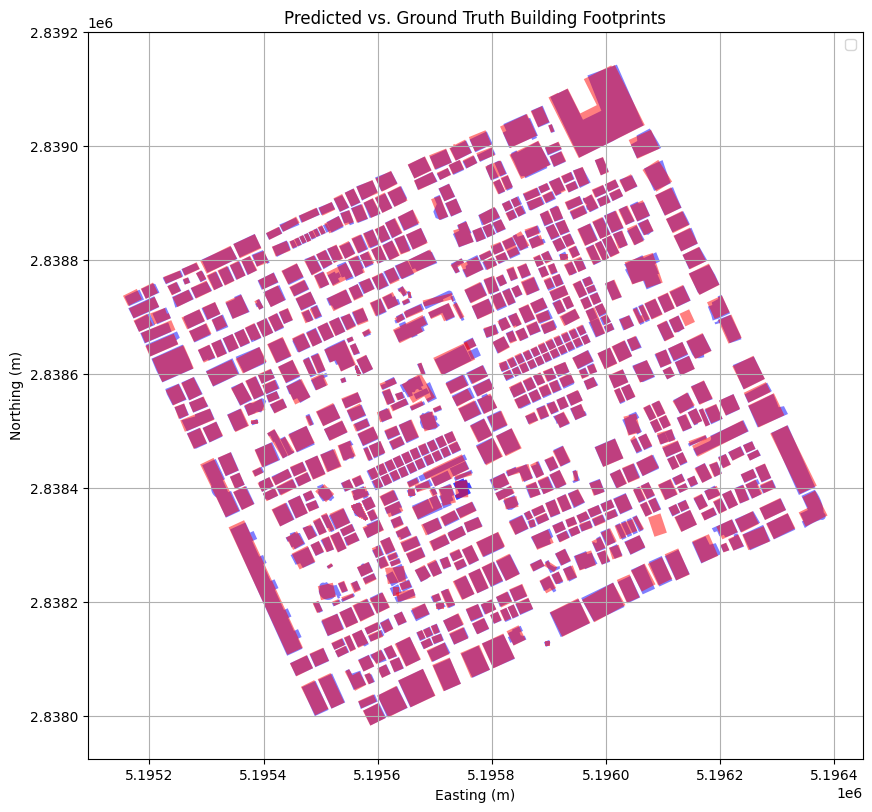

Plot saved to: accuracy_plots\footprint_comparison.png


In [19]:
# Visualize predicted vs. ground truth polygons
fig, ax = plt.subplots(figsize=(10, 10))

# Plot ground truth in blue
gt_gdf.plot(ax=ax, color='blue', alpha=0.5, label='Ground Truth')

# Plot predictions in red
pred_gdf.plot(ax=ax, color='red', alpha=0.5, label='Predictions')

plt.title('Predicted vs. Ground Truth Building Footprints')
plt.legend()
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.grid(True)

# Save plot
plot_path = output_dir / 'footprint_comparison.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Plot saved to: {plot_path}")

## Notes
- **Input Files**: Update `pred_geojson` and `gt_geojson` with your file paths (e.g., predictions from Mask R-CNN, ground truth from Address Layer).
- **IoU Threshold**: The default threshold (0.5) is standard for building detection. Adjust (e.g., 0.75 for stricter matching) based on KSA’s requirements.
- **KSA Challenges**: Spectral similarities (sand, roofs, yards) may lower precision. Use multispectral data or post-processing to improve results.
- **Scalability**: For large datasets (8,067,259 parcels), process in batches or use a smaller POC region.
- **Output**: Metrics and a comparison plot are saved for analysis.

$$ \sum_{k=1}^n k^2 = \frac{n(n+1)(2n+1)}{6} $$

\[
\text{F1} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
\]